1. Resize ảnh về kích thước thống nhất

In [22]:
# Tạo thư mục chứa dữ liệu đã tiền xử lý
import os
import cv2
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [23]:
# Các thư mục input và output
base_dir = "D:/MRI_4/dataset_1_reorganized"
processed_dir = "D:/MRI_4/dataset_1_processed"
target_size = (224, 224)  # Kích thước phổ biến cho nhiều mô hình CNN


In [24]:

# Tạo cấu trúc thư mục output
for split in ['train', 'validation', 'test']:
    for cls in ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]:
        os.makedirs(os.path.join(processed_dir, split, cls), exist_ok=True)


In [25]:
# Hàm resize ảnh và lưu vào thư mục mới
def resize_and_save(source_dir, target_dir, target_size):
    print(f"Đang xử lý thư mục: {source_dir}")
    files_processed = 0
    
    for cls in ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]:
        source_cls_dir = os.path.join(source_dir, cls)
        target_cls_dir = os.path.join(target_dir, cls)
        
        if not os.path.exists(source_cls_dir):
            continue
            
        files = [f for f in os.listdir(source_cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        for file in files:
            try:
                img_path = os.path.join(source_cls_dir, file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    # Resize ảnh
                    resized_img = cv2.resize(img, target_size)
                    # Lưu ảnh đã resize
                    cv2.imwrite(os.path.join(target_cls_dir, file), resized_img)
                    files_processed += 1
                else:
                    print(f"Lỗi: Không thể đọc ảnh {img_path}")
            except Exception as e:
                print(f"Lỗi khi xử lý {file}: {e}")
                
    print(f"Đã xử lý {files_processed} ảnh trong {source_dir}")


In [26]:
# Thực hiện resize cho cả 3 tập
for split in ['train', 'validation', 'test']:
    resize_and_save(
        os.path.join(base_dir, split),
        os.path.join(processed_dir, split),
        target_size
    )

Đang xử lý thư mục: D:/MRI_4/dataset_1_reorganized\train
Đã xử lý 4914 ảnh trong D:/MRI_4/dataset_1_reorganized\train
Đang xử lý thư mục: D:/MRI_4/dataset_1_reorganized\validation
Đã xử lý 1054 ảnh trong D:/MRI_4/dataset_1_reorganized\validation
Đang xử lý thư mục: D:/MRI_4/dataset_1_reorganized\test
Đã xử lý 1055 ảnh trong D:/MRI_4/dataset_1_reorganized\test


2. cân bằng dữ liệu bằng tăng cường

In [27]:
# Tạo thư mục cho dữ liệu đã cân bằng
balanced_dir = "D:/MRI_4/dataset_1_balanced"
os.makedirs(balanced_dir, exist_ok=True)

In [28]:
# Copy cấu trúc từ processed_dir
for split in ['train', 'validation', 'test']:
    for cls in ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]:
        os.makedirs(os.path.join(balanced_dir, split, cls), exist_ok=True)


In [29]:
# Copy validation và test nguyên vẹn
for split in ['validation', 'test']:
    for cls in ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]:
        source = os.path.join(processed_dir, split, cls)
        dest = os.path.join(balanced_dir, split, cls)
        if os.path.exists(source):
            for file in os.listdir(source):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    shutil.copy2(os.path.join(source, file), os.path.join(dest, file))


In [30]:
# Đếm số ảnh trong từng lớp của tập train
train_counts = {}
for cls in ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]:
    cls_dir = os.path.join(processed_dir, 'train', cls)
    if os.path.exists(cls_dir):
        train_counts[cls] = len([f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])


In [31]:
# Tìm lớp có nhiều ảnh nhất để làm mục tiêu cân bằng
target_count = max(train_counts.values())
print(f"Số lượng ảnh mỗi lớp sau khi cân bằng: {target_count}")

Số lượng ảnh mỗi lớp sau khi cân bằng: 1400


In [33]:
# Tăng cường dữ liệu cho các lớp ít ảnh
for cls in train_counts:
    if train_counts[cls] < target_count:
        source_dir = os.path.join(processed_dir, 'train', cls)
        target_dir = os.path.join(balanced_dir, 'train', cls)
        
        # Copy tất cả ảnh gốc trước
        for file in os.listdir(source_dir):
            if file.endswith(('.jpg', '.png', '.jpeg')):
                shutil.copy2(os.path.join(source_dir, file), os.path.join(target_dir, file))
        
        # Tính số ảnh cần tạo thêm
        augment_needed = target_count - train_counts[cls]
        print(f"Tạo thêm {augment_needed} ảnh cho lớp {cls}")
        
        # Tạo bộ sinh dữ liệu với các biến đổi đa dạng
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        # Lấy danh sách ảnh
        files = [f for f in os.listdir(source_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        aug_count = 0
        
        # Xử lý theo batch nhỏ để tiết kiệm bộ nhớ
        batch_size = 50  # Điều chỉnh số này tùy theo RAM của bạn
        
        for batch_start in range(0, len(files), batch_size):
            batch_files = files[batch_start:batch_start + batch_size]
            batch_images = []
            
            # Đọc batch ảnh
            for file in batch_files:
                if aug_count >= augment_needed:
                    break
                    
                img = cv2.imread(os.path.join(source_dir, file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                batch_images.append(img)
            
            if not batch_images:  # Thoát nếu không còn ảnh cần xử lý
                break
                
            batch_images = np.array(batch_images)
            
            # Tạo và lưu ảnh tăng cường
            for x_batch in datagen.flow(batch_images, batch_size=1, shuffle=True):
                aug_img = x_batch[0].astype(np.uint8)
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                aug_filename = f"{cls}_augmented_{aug_count}.jpg"
                cv2.imwrite(os.path.join(target_dir, aug_filename), aug_img)
                
                aug_count += 1
                if aug_count >= augment_needed:
                    break
    else:
        # Đối với lớp đã có đủ số lượng ảnh, chỉ cần copy
        source_dir = os.path.join(processed_dir, 'train', cls)
        target_dir = os.path.join(balanced_dir, 'train', cls)
        
        for file in os.listdir(source_dir):
            if file.endswith(('.jpg', '.png', '.jpeg')):
                shutil.copy2(os.path.join(source_dir, file), os.path.join(target_dir, file))

Tạo thêm 266 ảnh cho lớp Glioma
Tạo thêm 249 ảnh cho lớp Meningioma
Tạo thêm 171 ảnh cho lớp Pituitary


3. Chuẩn hóa giá trị pixel và tạo bộ tải dữ liệu

In [34]:
# Tạo các bộ tải dữ liệu để dùng trong huấn luyện
def create_dataset_generators(data_dir, batch_size=32):
    # Tăng cường nhẹ cho tập train khi huấn luyện (có thể bỏ nếu đã làm augmentation ở trên)
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Chuẩn hóa pixel về [0, 1]
        # Thêm augmentation nhẹ khi huấn luyện (tùy chọn)
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Chỉ rescale cho validation và test
    valid_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Tạo generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = valid_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'validation'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = valid_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator


In [35]:
# Tạo generators từ dữ liệu đã cân bằng
train_gen, val_gen, test_gen = create_dataset_generators(balanced_dir, batch_size=32)


Found 5600 images belonging to 4 classes.
Found 1054 images belonging to 4 classes.
Found 1055 images belonging to 4 classes.


In [36]:
print("Class indices (mapping giữa lớp và chỉ số):")
print(train_gen.class_indices)

print(f"Số batch trong tập train: {len(train_gen)}")
print(f"Số batch trong tập validation: {len(val_gen)}")
print(f"Số batch trong tập test: {len(test_gen)}")

Class indices (mapping giữa lớp và chỉ số):
{'Glioma': 0, 'Meningioma': 1, 'No_Tumor': 2, 'Pituitary': 3}
Số batch trong tập train: 175
Số batch trong tập validation: 33
Số batch trong tập test: 33


4. Kiểm tra lại dữ liệu đã tiền xử lý

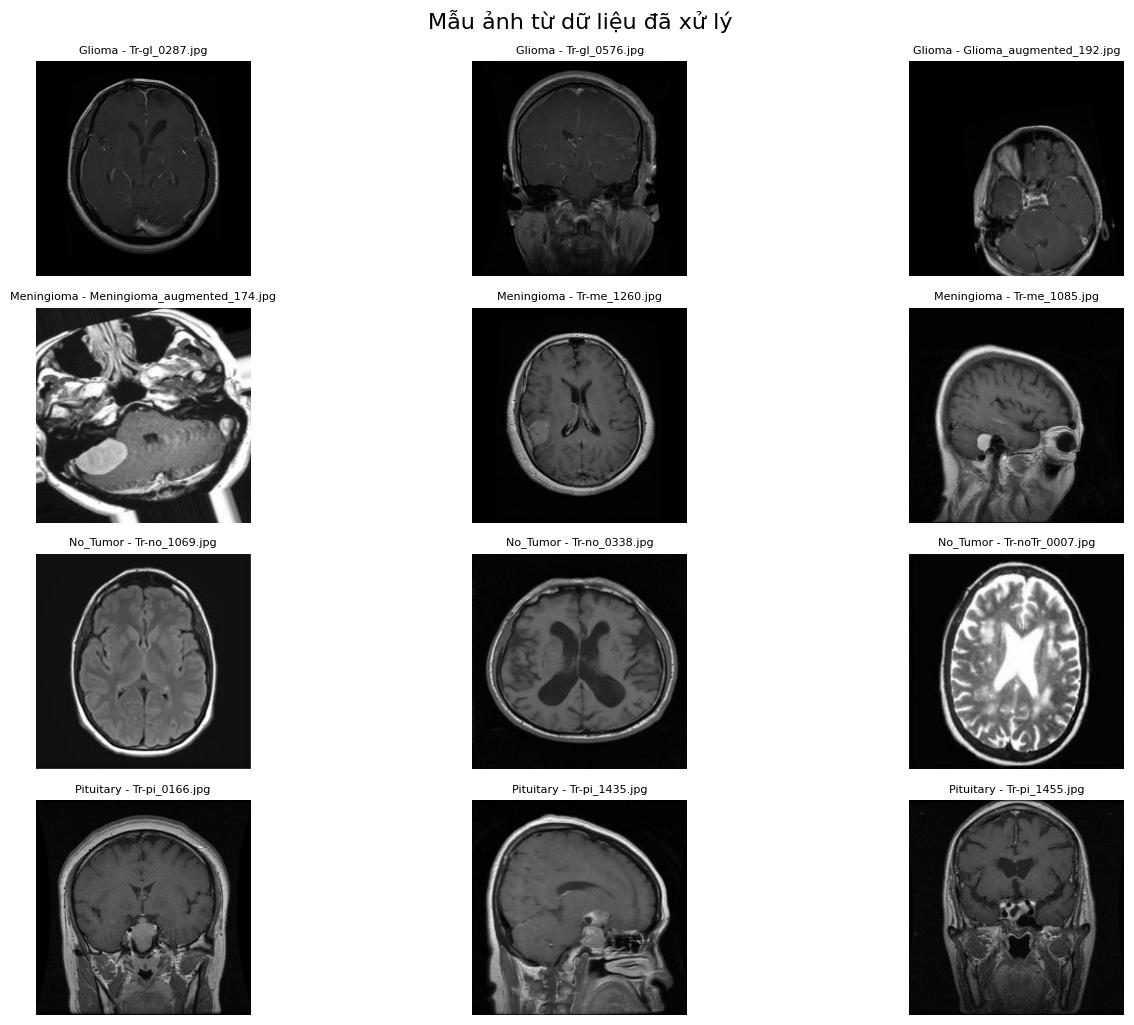

Phân phối dữ liệu sau khi tiền xử lý và cân bằng:
            train  validation  test
Glioma       1400         243   244
Meningioma   1400         247   247
No_Tumor     1400         300   300
Pituitary    1400         264   264


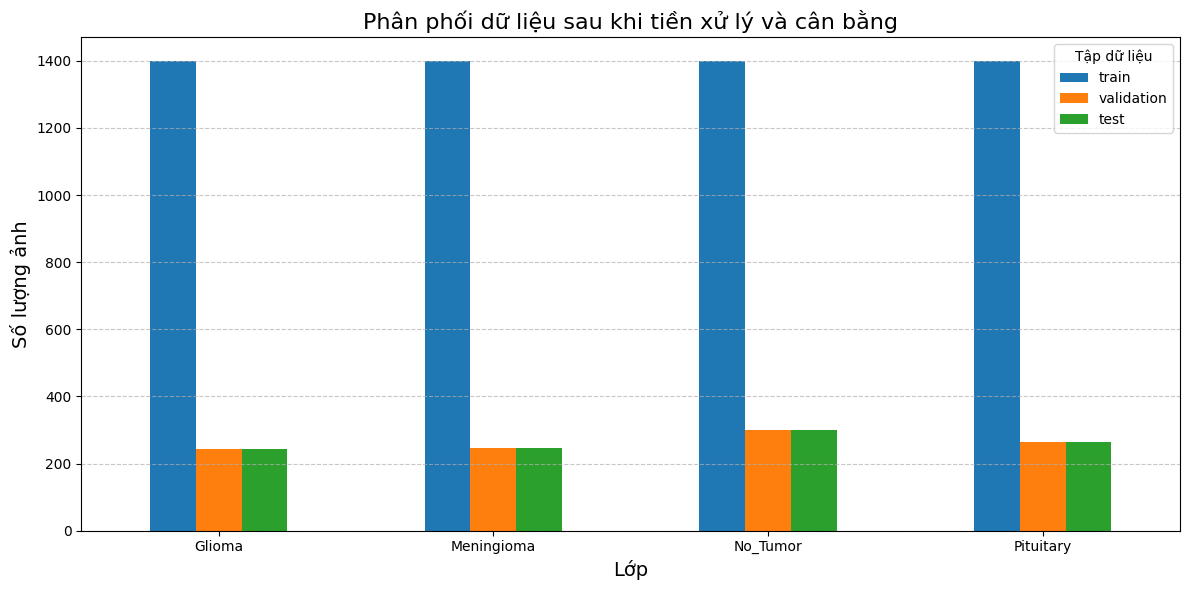

In [37]:
# Kiểm tra một số ảnh đã tiền xử lý và cân bằng
import matplotlib.pyplot as plt
import pandas as pd
import random

def display_processed_images(directory, num_samples=3):
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(["Glioma", "Meningioma", "No_Tumor", "Pituitary"]):
        cls_path = os.path.join(directory, 'train', cls)
        if not os.path.exists(cls_path):
            continue
            
        files = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if not files:
            continue
            
        sample_files = np.random.choice(files, min(num_samples, len(files)), replace=False)
        
        for j, file in enumerate(sample_files):
            img_path = os.path.join(cls_path, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(4, num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{cls} - {file}", fontsize=8)
            plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Mẫu ảnh từ dữ liệu đã xử lý', fontsize=16, y=1.02)
    plt.show()

# Hiển thị một số ảnh đã xử lý
display_processed_images(balanced_dir)

# Kiểm tra số lượng ảnh sau khi cân bằng
balanced_counts = {}
for split in ['train', 'validation', 'test']:
    balanced_counts[split] = {}
    for cls in ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]:
        cls_dir = os.path.join(balanced_dir, split, cls)
        if os.path.exists(cls_dir):
            balanced_counts[split][cls] = len([f for f in os.listdir(cls_dir) 
                                              if f.endswith(('.jpg', '.png', '.jpeg'))])

# Hiển thị kết quả
df_balanced = pd.DataFrame(balanced_counts)
print("Phân phối dữ liệu sau khi tiền xử lý và cân bằng:")
print(df_balanced)

# Vẽ biểu đồ phân phối sau khi cân bằng
plt.figure(figsize=(12, 6))
df_balanced.plot(kind='bar', ax=plt.gca())
plt.title('Phân phối dữ liệu sau khi tiền xử lý và cân bằng', fontsize=16)
plt.xlabel('Lớp', fontsize=14)
plt.ylabel('Số lượng ảnh', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Tập dữ liệu')
plt.tight_layout()
plt.show()